In [2]:
from keras.datasets import cifar10, mnist, fashion_mnist
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Input, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras import optimizers
import keras
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

170500096/170498071 [==============================] - 831s 5us/step


In [4]:
x_train, x_val = x_train.astype('float32')/255.,  x_val.astype('float32')/255.
y_train, y_val = to_categorical(y_train), to_categorical(y_val)

In [9]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect',
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [10]:
train_datagen.fit(x_train)

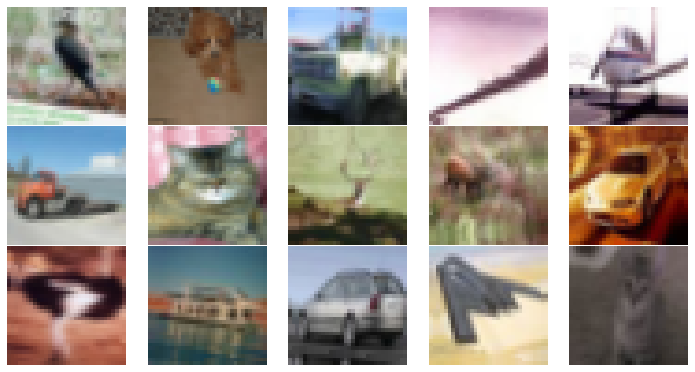

In [13]:
plt.figure(figsize=(10,5))

for X_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=15):
    for i in range(0, 15):
        plt.subplot(3, 5, i+1)
        plt.imshow(X_batch[i].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout(pad=0.1)
    plt.show()
    break

In [14]:
model = Sequential()
model.add(Conv2D(64,(3,3), activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
bs = 64
epochs = 15

In [16]:
history = model.fit_generator(train_datagen.flow(x_train, y_train,
                              batch_size=bs),
                              epochs=epochs,
                              steps_per_epoch=len(x_train)/bs,
                              validation_data=(x_val, y_val))


Epoch 1/15
782/781 [==============================] - 61s 79ms/step - loss: 1.6536 - accuracy: 0.3958 - val_loss: 1.3026 - val_accuracy: 0.5317
Epoch 2/15
782/781 [==============================] - 60s 77ms/step - loss: 1.3096 - accuracy: 0.5334 - val_loss: 1.0993 - val_accuracy: 0.6068
Epoch 3/15
782/781 [==============================] - 76s 97ms/step - loss: 1.1552 - accuracy: 0.5913 - val_loss: 0.9430 - val_accuracy: 0.6702
Epoch 4/15
782/781 [==============================] - 95s 121ms/step - loss: 1.0732 - accuracy: 0.6231 - val_loss: 0.9204 - val_accuracy: 0.6795
Epoch 5/15
782/781 [==============================] - 103s 132ms/step - loss: 1.0117 - accuracy: 0.6466 - val_loss: 0.8561 - val_accuracy: 0.7074
Epoch 6/15
782/781 [==============================] - 110s 141ms/step - loss: 0.9617 - accuracy: 0.6624 - val_loss: 0.8737 - val_accuracy: 0.6952
Epoch 7/15
782/781 [==============================] - 115s 147ms/step - loss: 0.9321 - accuracy: 0.6759 - val_loss: 0.8138 - val_a

In [17]:
print(f'Baseline accuracy: {model.evaluate(x_val, y_val)[1]}')

10000/10000 [==============================] - 8s 776us/step
Baseline accuracy: 0.7649999856948853


### Define the test Image Generator

In [18]:
tta_steps = 10

In [19]:
test_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [20]:
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(test_datagen.flow(x_val, batch_size=bs, shuffle=False), steps = len(x_val)/bs)
    predictions.append(preds)

100%|██████████| 10/10 [01:18<00:00,  7.87s/it]


In [21]:
final_pred = np.mean(predictions, axis=0)

In [22]:
print(f'Accuracy with TTA: {np.mean(np.equal(np.argmax(y_val, axis=-1), np.argmax(final_pred, axis=-1)))}')

Accuracy with TTA: 0.7834


### See the impact of TTA on a single image

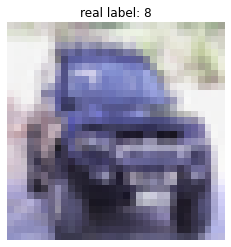

In [26]:

test_image = x_val[9]
plt.imshow(test_image)
plt.title(f'real label: {np.argmax(y_val[image_ix])}')
plt.axis('off');

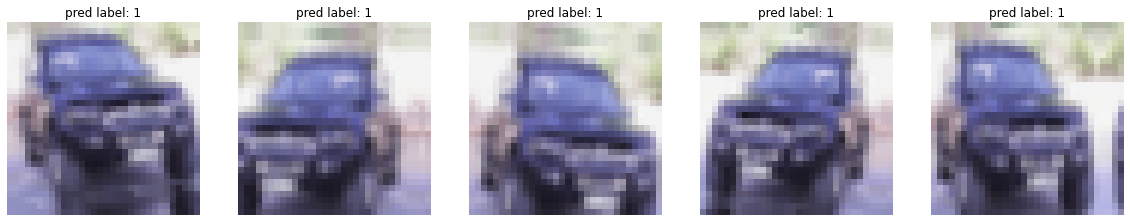

In [27]:
plt.figure(figsize=(20,14))
predictions = []

for i in range(5):
    im = test_datagen.flow(test_image.reshape(1,32,32,3), batch_size=1, shuffle=False)
    im = next(im)
    pred = model.predict(im.reshape(1,32,32,3))
    predictions.append(pred)
    plt.subplot(1, 5, i+1)
    plt.title(f'pred label: {np.argmax(pred)}')
    plt.imshow(im.reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

In [28]:
final_pred = np.mean(predictions, axis=0)
print(f'final pred: {np.argmax(final_pred)}')

final pred: 1
